#### Imports

In [1]:
import numpy as np
import os

from spiegelib.estimator import ParameterLoss
from matplotlib import pyplot as plt
import seaborn as sns
import spiegelib as spgl
import itertools
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

sns.set_theme()

#### All metrics are defined here

In [2]:
def calculateMPE(truePatches, predictedPatches):
    """
    Calculates the mean absolute parameter error
    Args:
        truePatches:
        predictedPatches:

    Returns: a list of mean errors for each parameter and std errors
    """
    errors = []
    for true, predicted in zip(truePatches, predictedPatches):
        patchErrors = []
        for trueParam, predictedParam in zip(true, predicted):
            error = abs(trueParam - predictedParam)
            patchErrors.append(error)
        errors.append(patchErrors)
    errors_mean = np.mean(np.array(errors), axis=0)
    errors_std = np.std(np.array(errors), axis=0)
    return errors_mean, errors_std

In [3]:
def calculateMAE(truePatches, predictedPatches):
    errors = []
    for true, predicted in zip(truePatches, predictedPatches):
        patchError = 0
        for i, (trueParam, predictedParam) in enumerate(zip(true, predicted)):
            error = abs(trueParam - predictedParam)
            patchError += error
        #Calculate avg parameter error of a sample
        patchError = patchError / len(true)
        errors.append(patchError)
    errors = np.array(errors)
    mean = np.mean(errors)
    std = np.std(errors)
    return errors, mean, std

In [4]:
def calculateMFCC(trueAudio, predictedAudio):
    evaluation = spgl.evaluation.MFCCEval(trueAudio, predictedAudio)
    evaluation.evaluate()
    mfccDistances = []
    for key, value in evaluation.get_scores().items():
        error = value['source_0']['mean_abs_error']
        mfccDistances.append(error)
    mfccDistances = np.array(mfccDistances)
    mean = np.mean(mfccDistances)
    std = np.std(mfccDistances)
    return mfccDistances, mean, std

### Load all data

In [5]:
datasetName = "evaluation"

automatableKeys = np.load("../data/presets/lfo/automatable_12.npy", allow_pickle=True)
weightsDict = np.load("../data/presets/lfo/weights_12.npy", allow_pickle=True).item()
weights = [weightsDict.get(key) for key in automatableKeys]

parameterModel = np.load("../data/presets/allParamsUpdatedNew.npy", allow_pickle=True)

#True audio and patches
true_audio = spgl.AudioBuffer.load_folder(f"../data/{datasetName}/audio")
true_patch = np.load(f"../data/{datasetName}/patch/patches.npy", allow_pickle=True)


#Load all configs:

#Run all configurations!
allBins = [4, 8, 12, 16, 32]
allDatasets = ["uniform", "preset", "normal"]
pred_audio = {}
pred_patch = {}

#Setup and load metric scores
mfcc_scores = np.load(f"../data/{datasetName}/scores/mfcc.npy", allow_pickle=True).item()
mpe_scores = np.load(f"../data/{datasetName}/scores/mpe.npy", allow_pickle=True).item()
mae_scores = np.load(f"../data/{datasetName}/scores/mae.npy", allow_pickle=True).item()

for dataset, bins in list(itertools.product(allDatasets, allBins)):
    pred_audio[(dataset, bins)] = [spgl.AudioBuffer.load_folder(f"../data/{datasetName}/predict_{dataset}_{bins}")]
    pred_patch[(dataset, bins)] = np.load(f"../data/{datasetName}/predict_{dataset}_{bins}/params.npy", allow_pickle=True)


C:\Users\hugod\Anaconda3\envs\spiegelib\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [55]:
#Human study
human_study = pd.read_csv(f"../data/{datasetName}/human/humanstudy.csv")
mfcc_study = np.load(f"../data/{datasetName}/human/mfccs.npy")
mae_study = np.load(f"../data/{datasetName}/human/maes.npy")

### Plot MPE

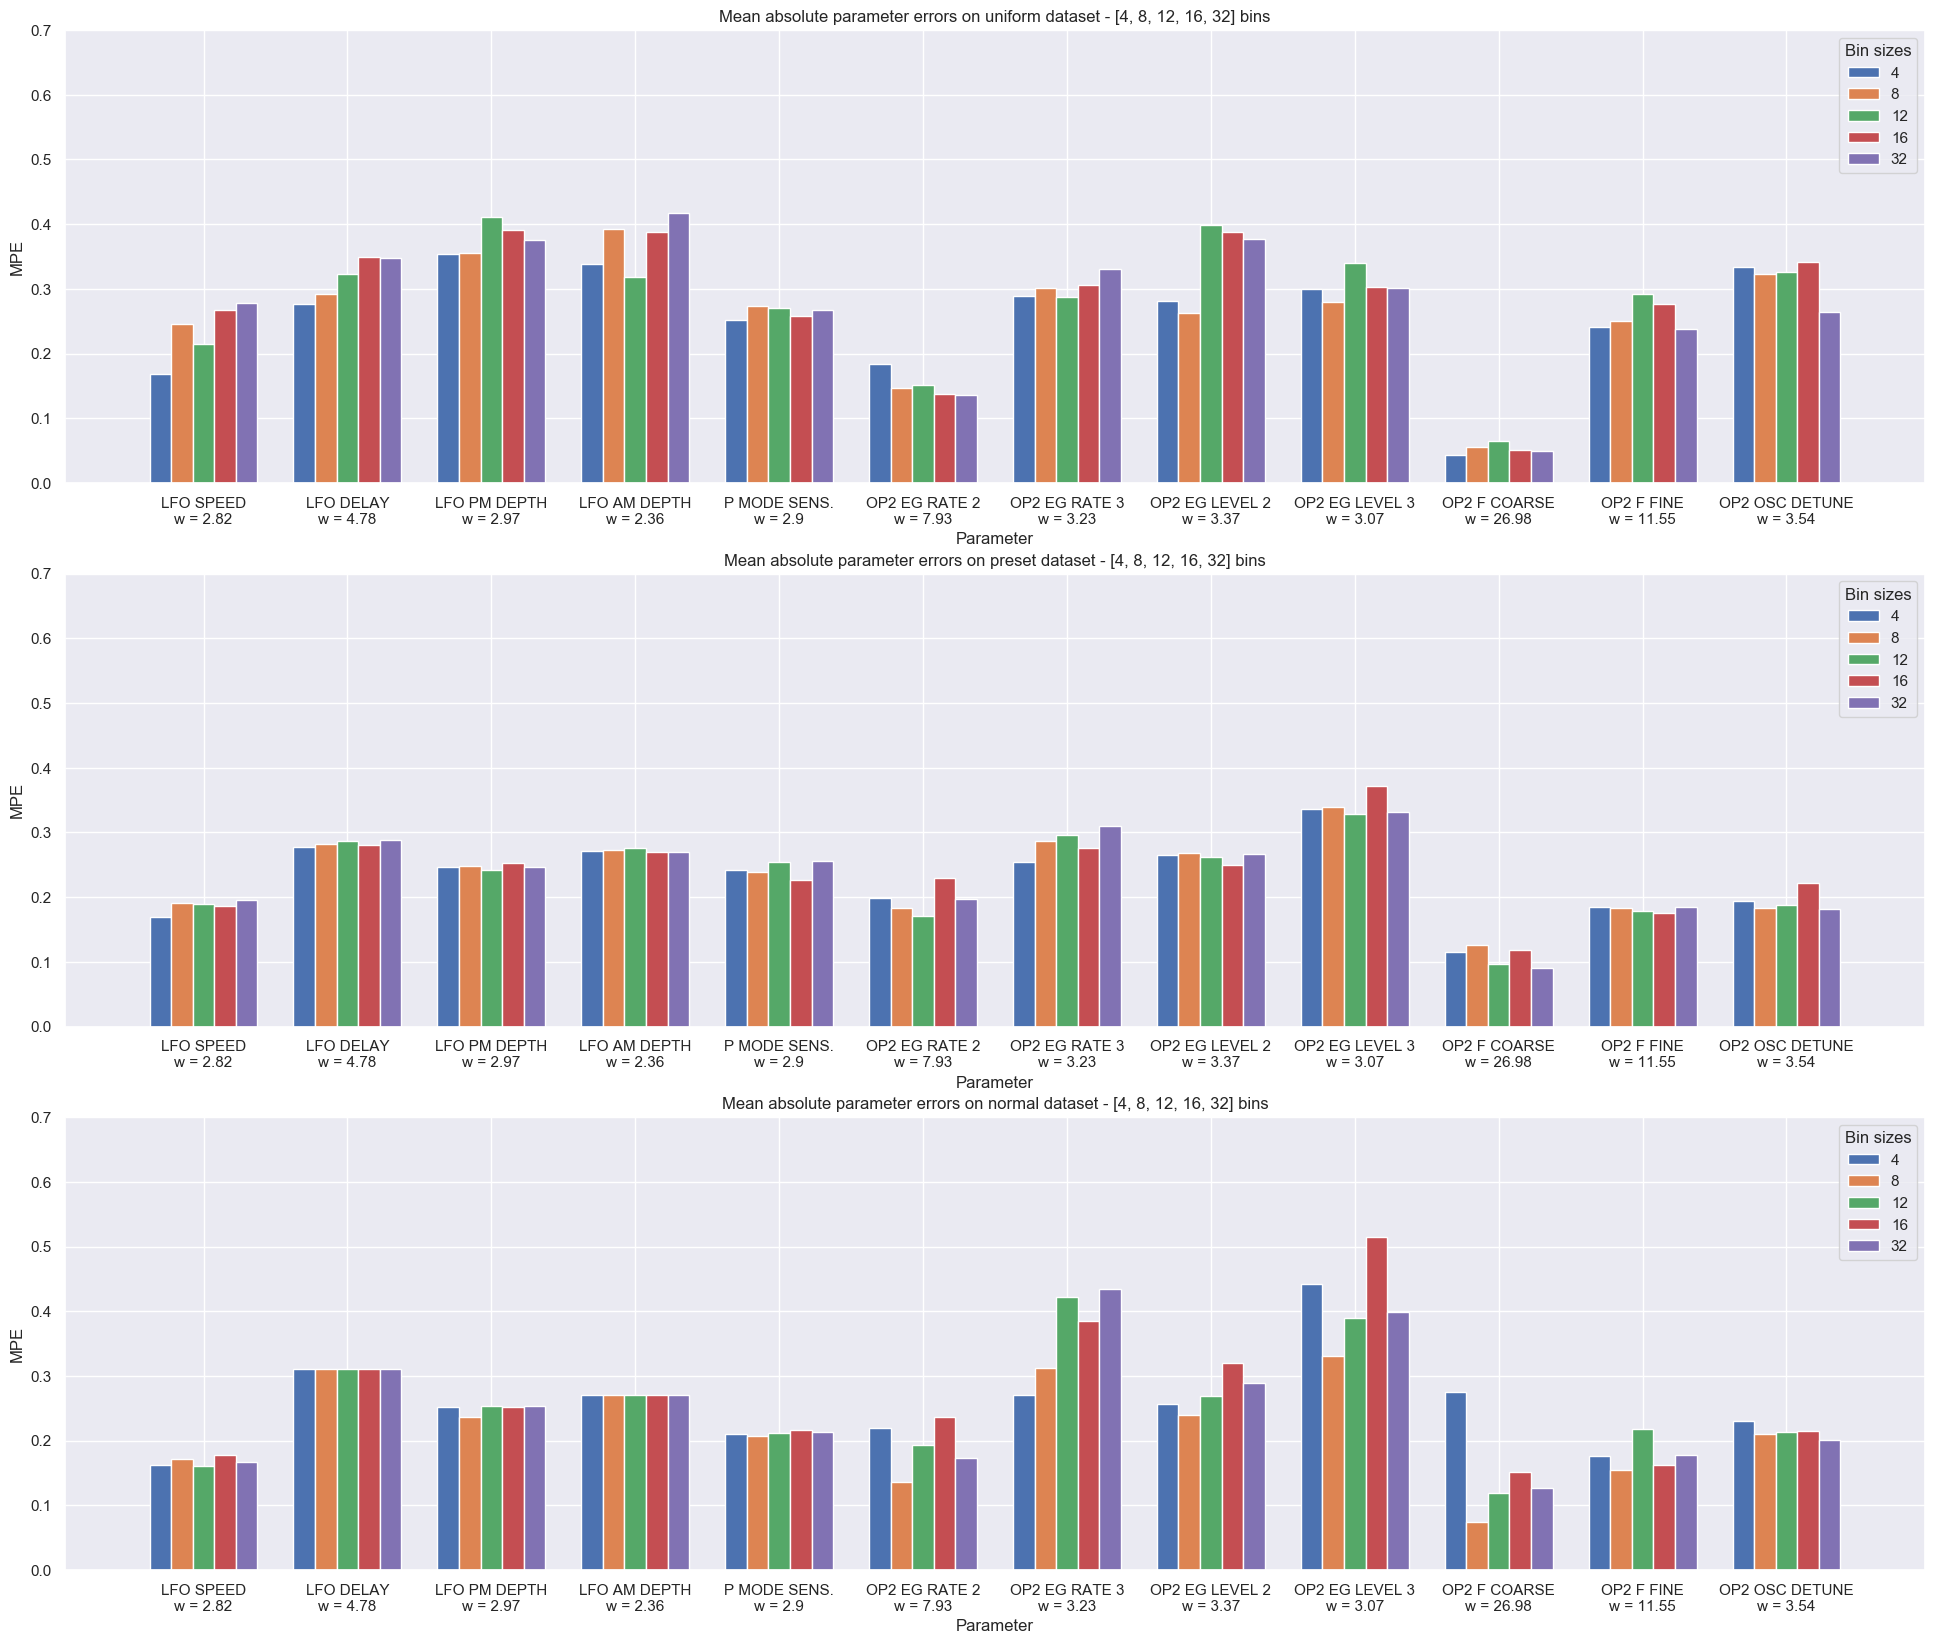

In [70]:
#Generate 3 plots for each dataset (now only 2)

fix, axes = plt.subplots(3, 1, figsize=(2 * len(automatableKeys), 20))

n = len(automatableKeys)
r = np.arange(n)

for ax, currDataset in zip(axes, allDatasets):
    width = 0.15
    position = - width * 2
    x_bar = [x['name'] + f"\nw = {str(round(y, 2))}" for x, y in zip(parameterModel[automatableKeys], weights)]
    for bin in allBins:
        #Calculate mpe and store in dict
        # mpe, mpe_std = calculateMPE(true_patch, pred_patch[(currDataset, bin)])
        # mpe_scores[(currDataset, bin)] = (mpe, mpe_std)
        mpe, mpe_std = mpe_scores[(currDataset, bin)]
        #Plot the bar
        ax.bar(r + position, height=mpe, width= width)
        position += width

    ax.legend(allBins, title="Bin sizes")
    ax.set_xlabel("Parameter")
    ax.set_ylabel("MPE")
    ax.set_title(f"Mean absolute parameter errors on {currDataset} dataset - {str(allBins)} bins")
    ax.set_xticks(r)
    ax.set_xticklabels(x_bar)
    ax.set_ylim(0,0.7)

plt.savefig("../data/plots/MPE.png")

plt.show()

### Plot MFCC

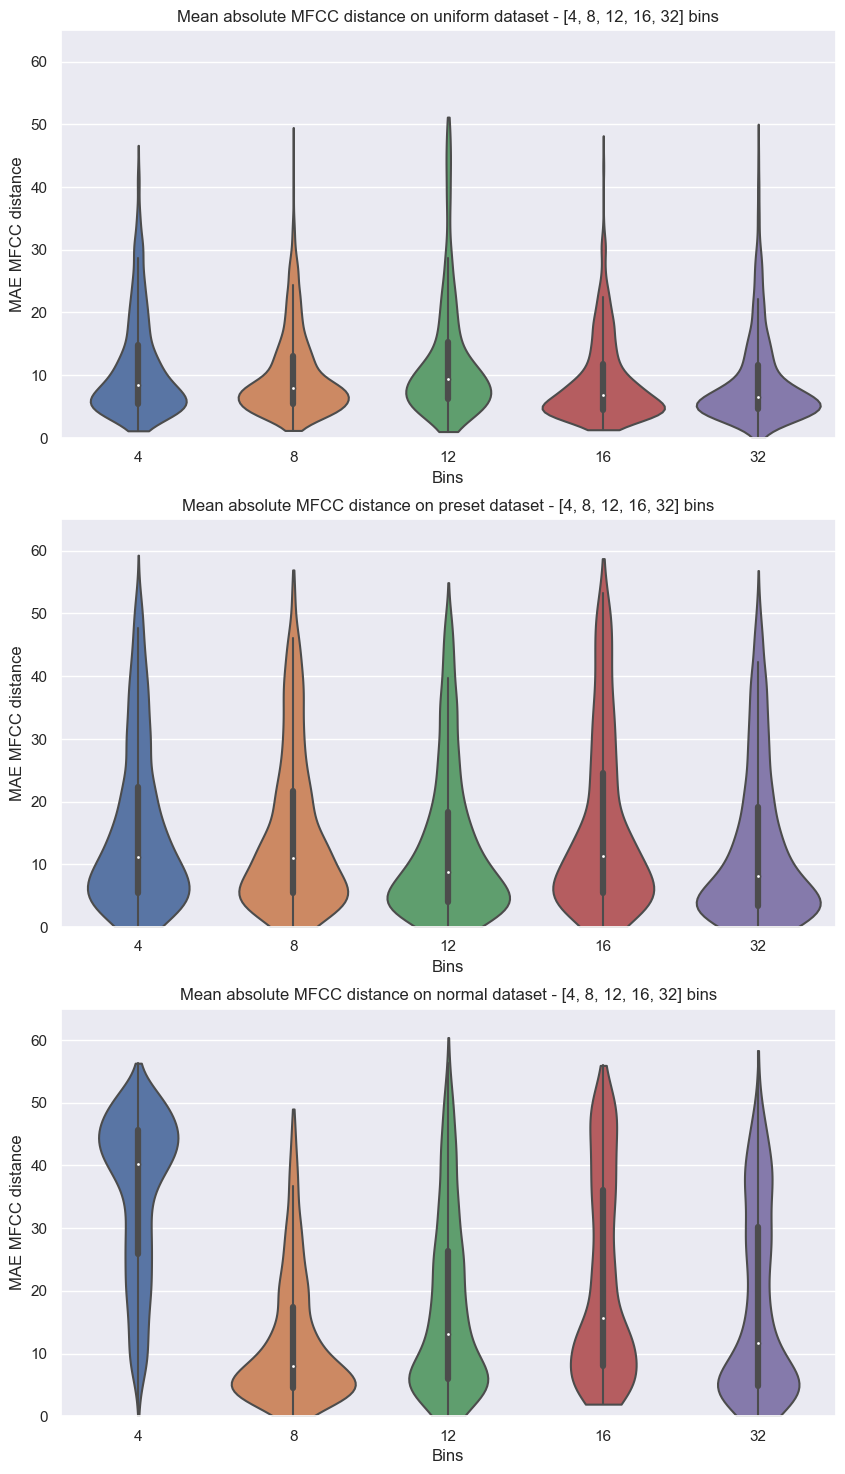

In [73]:
#Generate 3 plots for each dataset (now only 2)

fix, axes = plt.subplots(3, 1, figsize=(10, 18))

n = len(automatableKeys)
r = np.arange(n)

mfcc_scores = {}

for ax, currDataset in zip(axes, allDatasets):
    dataDict = {}
    for bin in allBins:
        #Calculate mfcc and store in dict
        mfcc, mfcc_mean, mfcc_std = calculateMFCC(true_audio, pred_audio[(currDataset, bin)])
        mfcc_scores[(currDataset, bin)] = (mfcc, mfcc_mean, mfcc_std)

        #(mfcc, mfcc_mean, mfcc_std) = mfcc_scores[(currDataset, bin)]
        dataDict[bin] = mfcc
    df = pd.DataFrame.from_dict(dataDict)
    sns.violinplot(df, ax=ax, cut = 0)
    ax.set_ylabel("MAE MFCC distance")
    ax.set_xlabel("Bins")
    ax.set_title(f"Mean absolute MFCC distance on {currDataset} dataset - {str(allBins)} bins")
    ax.set_ylim(0, 65)


plt.savefig("../data/plots/MFCC.png")

plt.show()

### Plot MAE over all samples

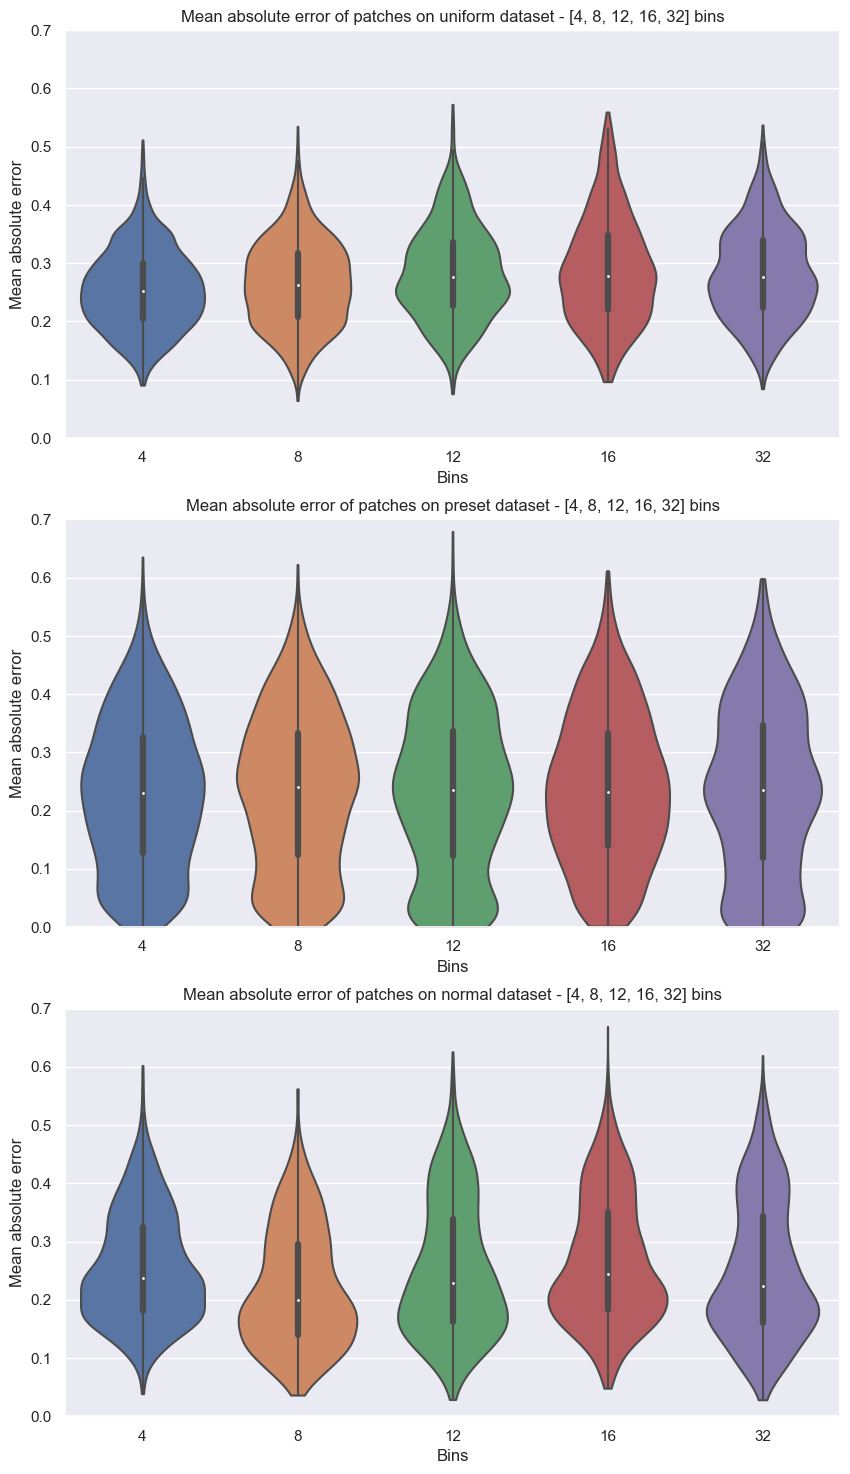

In [14]:
#Generate 3 plots for each dataset (now only 2)

fix, axes = plt.subplots(3, 1, figsize=(10, 18))

n = len(automatableKeys)
r = np.arange(n)

for ax, currDataset in zip(axes, allDatasets):
    dataDict = {}
    for bin in allBins:
        #Calculate mfcc and store in dict
        mae, mae_mean, mae_std = calculateMAE(true_patch, pred_patch[(currDataset, bin)])
        mae_scores[(currDataset, bin)] = (mae, mae_mean, mae_std)
        dataDict[bin] = mae
    df = pd.DataFrame.from_dict(dataDict)
    sns.violinplot(df, ax=ax, cut=0)
    ax.set_ylabel("Mean absolute error")
    ax.set_xlabel("Bins")
    ax.set_title(f"Mean absolute error of patches on {currDataset} dataset - {str(allBins)} bins")
    ax.set_ylim(0, 0.7)


plt.savefig("../data/plots/MAE.png")

plt.show()

### Correlation analysis between MFCC and MAE

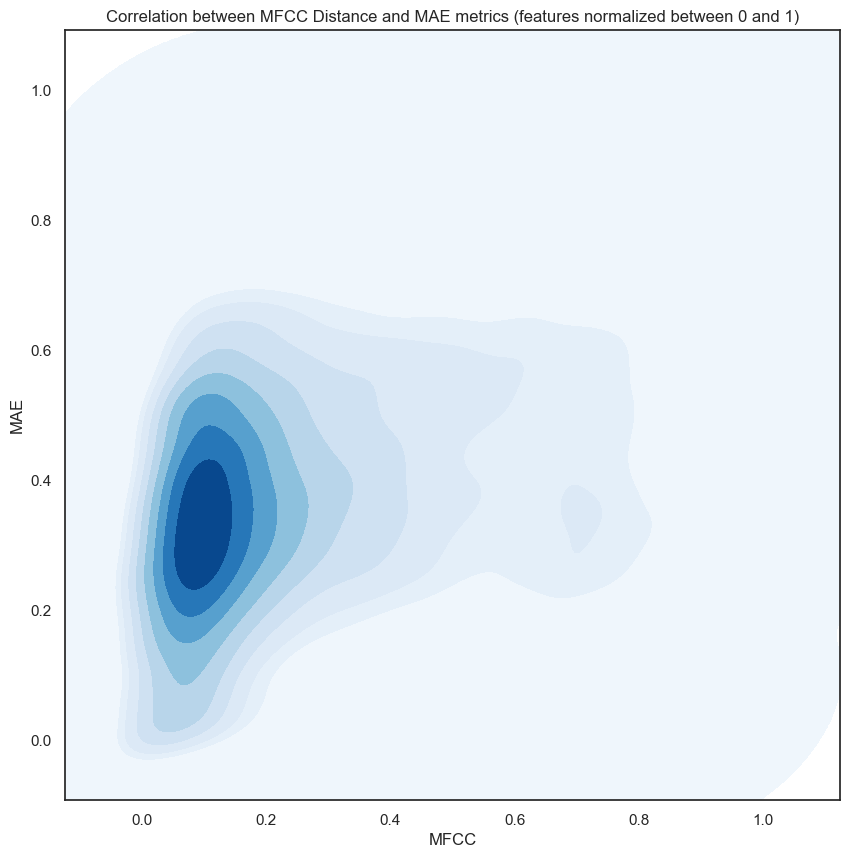

In [11]:
#Generate 3 plots for each dataset (now only 2)

fix, axes = plt.subplots(1, 1, figsize=(10, 10))
totalMFCC = np.array([])
totalMAE = np.array([])
plotDict = {}

for currDataset in allDatasets:
    for bin in allBins:
        #Get scores for current configuration
        currMFCC = np.array(mfcc_scores[(currDataset, bin)][0])
        currMAE = np.array(mae_scores[(currDataset, bin)][0])
        totalMFCC = np.concatenate((totalMFCC, currMFCC))
        totalMAE = np.concatenate((totalMAE, currMAE))

#Create dict from data
plotDict['MFCC'] = totalMFCC
plotDict['MAE'] = totalMAE
df2 = pd.DataFrame.from_dict(plotDict)

#Normalize features between 0 and 1
scale_norm = MinMaxScaler()
scale_norm.fit_transform(df2)
df2 = pd.DataFrame(scale_norm.fit_transform(df2), columns = df2.columns)

sns.set_style("white")

sns.kdeplot(x=df2['MFCC'], y = df2['MAE'], cmap="Blues", fill=True, thresh=0)
plt.title(f"Correlation between MFCC Distance and MAE metrics (features normalized between 0 and 1)")


plt.savefig("../data/plots/Corr.png")

plt.show()

### Preprocess human evaluation

In [56]:
#Remove the first 6 columns (timestamp + 5 example questions)
n = 6
study = human_study.iloc[: , n:]

#Rename all columns
questions = 18
renameColumns = {}
allColumns = study.columns
for i in range(0,  questions):
    currQuestion = f"Question {i + 1}"
    renameColumns[allColumns[i]] = currQuestion
study = study.rename(columns=renameColumns)

#Convert string to likert scale
remapDict = {"Totally Dissimilar": 4, "Dissimilar": 3, "Similar": 2, "Very Similar": 1, "Identical": 0}
remapInv = {v: k for k, v in remapDict.items()}
study = study.replace(remapDict)

#Specify question columns
uniformQuestions = [1,3,7,8,13,17]
normalQuestions = [6,9,10,14,15,16]
presetQuestions = [0,2,4,5,11,12]

#Calculate means per question
uniformDf = study.iloc[:, uniformQuestions]
normalDf = study.iloc[:, normalQuestions]
presetDf = study.iloc[:, presetQuestions]

uniformResults = uniformDf.mean(axis = 0).values
uniformResults = np.append(uniformResults, np.mean(uniformResults))

normalResults = normalDf.mean(axis = 0).values
normalResults = np.append(normalResults, np.mean(normalResults))

presetResults = presetDf.mean(axis = 0).values
presetResults = np.append(presetResults, np.mean(presetResults))

humanResults = [uniformResults, normalResults, presetResults]

### Calculate mae on evaluation samples

In [60]:
pred_samples = [1485, 1497, 4, 496, 500, 501]
configurations = [("uniform", 16), ("normal", 8), ("preset", 32)]
pred_human_patch = [pred_patch[x] for x in configurations]
true_human_patch = true_patch[pred_samples]
mae_study = []
for i, currPatch in enumerate(pred_human_patch):
    predPatches = currPatch[pred_samples]
    mae_error, mean, std = calculateMAE(true_human_patch, predPatches)
    mae_error = np.append(mae_error, mean)
    mae_study.append(mae_error)

### Plot human study results

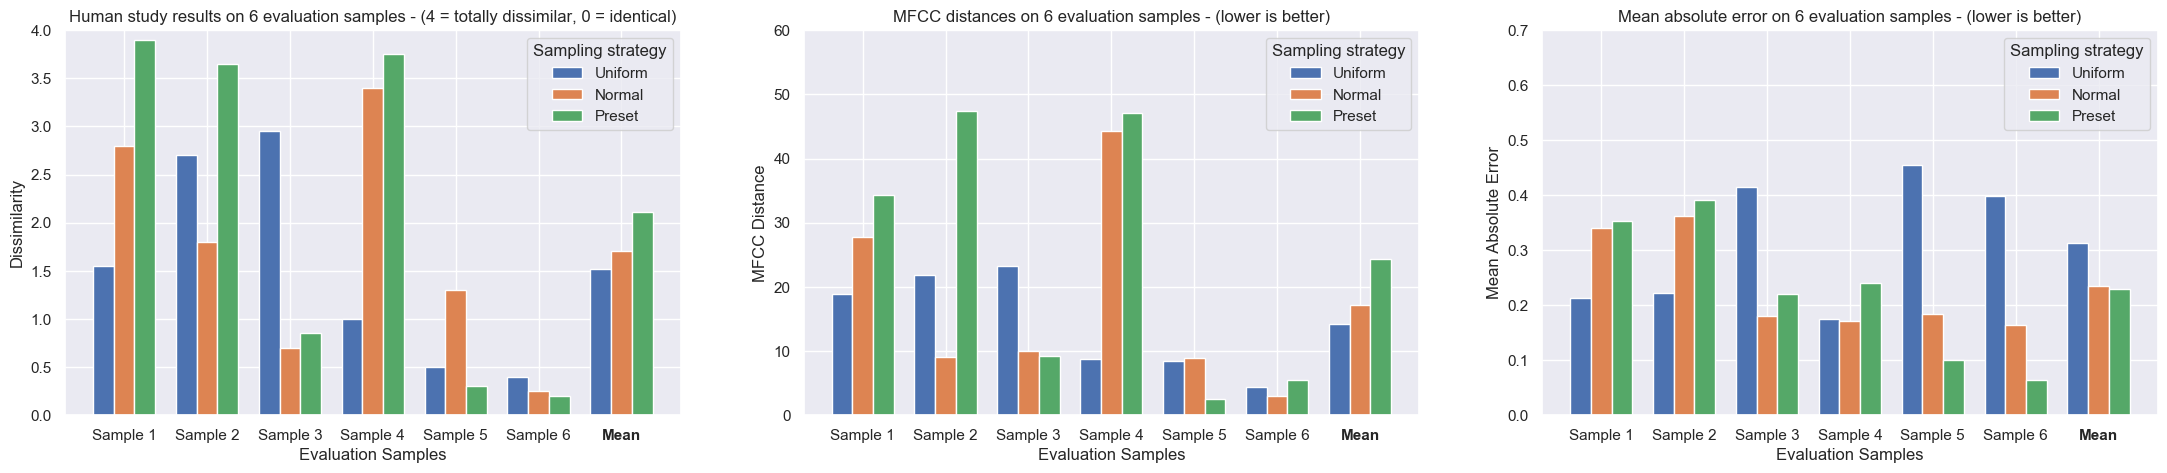

In [58]:
#Generate 3 plots for each dataset (now only 2)

fix, axes = plt.subplots(1, 3, figsize=(27, 5))

xLabels = ["Sample 1", "Sample 2", "Sample 3", "Sample 4", "Sample 5", "Sample 6", "Mean"]
n = len(xLabels)
r = np.arange(n)

width = 0.25
position = 0

humanStudy = [humanResults, mfcc_study, mae_study]
for i, (ax, results) in enumerate(zip(axes, humanStudy)):
    for result in results:
        ax.bar(r + position, height=result, width=width)
        position += width
    position = 0
    #Set global chart values
    ax.legend(["Uniform", "Normal", "Preset"], title="Sampling strategy")
    ax.set_xlabel("Evaluation Samples")
    ax.set_xticks(r + width)
    ax.set_xticklabels(xLabels[:7])
    ax.get_xticklabels()[-1].set_fontweight("bold")

axes[0].set_title(f"Human study results on 6 evaluation samples - (4 = totally dissimilar, 0 = identical)")
axes[1].set_title(f"MFCC distances on 6 evaluation samples - (lower is better)")
axes[2].set_title(f"Mean absolute error on 6 evaluation samples - (lower is better)")
#Set specific chart labels
axes[0].set_ylabel("Dissimilarity")
axes[1].set_ylabel("MFCC Distance")
axes[2].set_ylabel("Mean Absolute Error")

axes[0].set_ylim(0,4)
axes[1].set_ylim(0,60)
axes[2].set_ylim(0,0.7)

plt.savefig("../data/plots/HumanStudy.png")

plt.show()

### Save scores

In [151]:
#Save scores: mfcc and MPE
np.save(f"../data/{datasetName}/scores/mfcc.npy", mfcc_scores)
np.save(f"../data/{datasetName}/scores/mpe.npy", mpe_scores)
np.save(f"../data/{datasetName}/scores/mae.npy", mae_scores)
np.save(f"../data/{datasetName}/human/maes.npy", mae_study)

### Show all scores

In [72]:


#CHECK IF DICTS KEYS ARE IN SAME ORDER!!
# for mpe, mae, mfcc in zip(mpe_scores.items(), mae_scores.items(), mfcc_scores.items()):
#     key = mpe[0]
#     print(f"Curr key: {key}")
#     print("MPE - MAE - MFCC")
#     mpeRounded = list(np.round(mpe[1][0], 2))
#     totalMPE.append(mpeRounded)
#     #print(f" mean: {mpe[1:-1].replace('  ', ' ').replace(' ', ' & ')}")
#     #print(f" mean: {round(mae[1][1], 3)} std: {round(mae[1][2], 3)}")
#     print(f" mean: {round(float(mfcc[1][1]), 3)} std: {round(float(mfcc[1][2]), 3)}")

totalMPE = []

for mpe in mpe_scores.items():
    key = mpe[0]
    print(f"Curr key: {key}")
    print("MPE - MAE - MFCC")
    mpeRounded = list(np.round(mpe[1][0], 2))
    totalMPE.append(mpeRounded)

totalMPE = np.transpose(np.array(totalMPE))

for row in totalMPE:
    row = str(list(row))[1:-1]
    print(f" mean: {row.replace(', ', ' ').replace(' ', ' & ')}")

Curr key: ('uniform', 4)
MPE - MAE - MFCC
Curr key: ('uniform', 8)
MPE - MAE - MFCC
Curr key: ('uniform', 12)
MPE - MAE - MFCC
Curr key: ('uniform', 16)
MPE - MAE - MFCC
Curr key: ('uniform', 32)
MPE - MAE - MFCC
Curr key: ('preset', 4)
MPE - MAE - MFCC
Curr key: ('preset', 8)
MPE - MAE - MFCC
Curr key: ('preset', 12)
MPE - MAE - MFCC
Curr key: ('preset', 16)
MPE - MAE - MFCC
Curr key: ('preset', 32)
MPE - MAE - MFCC
Curr key: ('normal', 4)
MPE - MAE - MFCC
Curr key: ('normal', 8)
MPE - MAE - MFCC
Curr key: ('normal', 12)
MPE - MAE - MFCC
Curr key: ('normal', 16)
MPE - MAE - MFCC
Curr key: ('normal', 32)
MPE - MAE - MFCC
 mean: 0.17 & 0.25 & 0.22 & 0.27 & 0.28 & 0.17 & 0.19 & 0.19 & 0.19 & 0.2 & 0.16 & 0.17 & 0.16 & 0.18 & 0.17
 mean: 0.28 & 0.29 & 0.32 & 0.35 & 0.35 & 0.28 & 0.28 & 0.29 & 0.28 & 0.29 & 0.31 & 0.31 & 0.31 & 0.31 & 0.31
 mean: 0.35 & 0.35 & 0.41 & 0.39 & 0.38 & 0.25 & 0.25 & 0.24 & 0.25 & 0.25 & 0.25 & 0.24 & 0.25 & 0.25 & 0.25
 mean: 0.34 & 0.39 & 0.32 & 0.39 & 0.42 & 